In [1]:
# 测试逻辑回归解析解的效果

import numpy as np
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model
from bert4keras.snippets import sequence_padding
from bert4keras.snippets import open
from bert4keras.optimizers import Adam
from bert4keras.backend import keras
from keras.layers import *
from keras.models import Model
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:

maxlen = 128

# bert配置
config_path = './第十八组/中文自然语言模型/bert_config.json'
checkpoint_path = './第十八组/中文自然语言模型/bert_model.ckpt'
dict_path = './第十八组/中文自然语言模型/vocab.txt'

# 建立分词器
tokenizer = Tokenizer(dict_path, do_lower_case=True)  # 建立分词器

# 建立加载模型
encoder = build_transformer_model(
    config_path, checkpoint_path, model='roformer', with_pool='linear'
)


In [3]:


def load_data(filename):
    """加载数据
    单条格式：(文本, 标签id)
    """
    D = []
    with open(filename, encoding='utf-8') as f:
        for l in f:
            text, label = l.strip().split('\t')
            D.append((text, int(label)))
    return D


# 加载数据集
train_data = load_data('./第十八组/情感分类数据/sentiment.train.data')
valid_data = load_data('./第十八组/情感分类数据/sentiment.valid.data')
test_data = load_data('./第十八组/情感分类数据/sentiment.test.data')



In [4]:
import tensorflow as tf
print("GPU可用:",len(tf.config.experimental.list_physical_devices('GPU')))

GPU可用: 0


In [5]:
# #将语言数值化
# def convert(data):
#     X, S, Y = [], [], []
#     for t, l in tqdm(data):
#         x, s = tokenizer.encode(t, maxlen=maxlen)
#         X.append(x)
#         S.append(s)
#         Y.append([l])
#     X = sequence_padding(X)
#     S = sequence_padding(S)
#     X = encoder.predict([X, S], verbose=True)
#     Y = np.array(Y)
#     return X, Y
# train_x, train_y = convert(train_data)
# valid_x, valid_y = convert(valid_data)
# test_x, test_y = convert(test_data)


In [6]:
# print(type(train_x))

In [7]:
# #将语言数值化的数据永久保存
# np.savez('train_date_xulie.npz',train_x=train_x,train_y=train_y)
# np.savez('valid_date_xulie.npz',valid_x=train_x,valid_y=train_y)
# np.savez('test_date_xulie.npz',test_x=train_x,test_y=train_y)

In [8]:
#加载语言数值化数据
train=np.load('train_date_xulie.npz')
train_x=train['train_x']
train_y=train['train_y']

valid=np.load('valid_date_xulie.npz')
valid_x=valid['valid_x']
valid_y=valid['valid_y']

test=np.load('test_date_xulie.npz')
test_x=test['test_x']
test_y=test['test_y']

In [9]:

def compute_kernel_bias(vecs):
    mu = vecs.mean(axis=0, keepdims=True)
    cov = np.cov(vecs.T)
    u, s, vh = np.linalg.svd(cov)
    W = u.dot(np.diag(1 / np.sqrt(s)))
    return W, -mu


# 数据白化
kernel, bias = compute_kernel_bias(train_x)
train_x = (train_x + bias).dot(kernel)
valid_x = (valid_x + bias).dot(kernel)
test_x = (test_x + bias).dot(kernel)


In [10]:

# ============== 通过梯度下降求解 ==============

x = Input(shape=(train_x.shape[1],))
y = Dense(1, activation='sigmoid')(x)

model = Model(x, y)
model.compile(
    loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy']
)
model.summary()

model.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size=32,
    validation_data=(valid_x, valid_y)
)

train_y_pred = model.predict(train_x, verbose=True)
valid_y_pred = model.predict(valid_x, verbose=True)
test_y_pred = model.predict(test_x, verbose=True)
train_acc = np.mean((train_y == 1) == (train_y_pred > 0.5))
valid_acc = np.mean((valid_y == 1) == (valid_y_pred > 0.5))
test_acc = np.mean((test_y == 1) == (test_y_pred > 0.5))
print(train_acc, valid_acc, test_acc)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
Train on 16883 samples, validate on 16883 samples
Epoch 1/10
16883/16883 [==============================] - 2s 91us/step - loss: 0.6155 - accuracy: 0.6749 - val_loss: 0.4430 - val_accuracy: 0.8182
Epoch 2/10
16883/16883 [==============================] - 2s 92us/step - loss: 0.4233 - accuracy: 0.8241 - val_loss: 0.3863 - val_accuracy: 0.8411
Epoch 3/10
16883/16883 [==============================] - 1s 86us/step - loss: 0.3943 - accuracy: 0.8295 - val_loss: 0.3722 - val_accuracy: 0.8442
Epoch 4/10
16883/16883 [========

In [11]:
#用混淆矩阵分析分析情感分类数据上的训练和测试结果
test_y1=[ i for i in test_y]
test_y_pred0=np.around(test_y_pred,0).astype(int)
test_y_pred1=[ i for i in test_y_pred0]
cm=confusion_matrix(test_y1,test_y_pred1)
print(test_y1)
print(test_y_pred1)
# print(cm)

[array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), arr

In [12]:
#准确率
print(cm)
TP=cm[0,0]
FP=cm[1,0]
FN=cm[0,1]
TN=cm[1,1]
print("TP: ",TP)
print("FP: ",FP)
print("FN: ",FN)
print("TN: ",TN)
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
f1=2*precision*recall/(precision+recall)
print("准确率: ",accuracy)
print("精确率: ",precision)
print("召回率: ",recall)
print("f1的值: ",f1)

[[7004 1291]
 [1318 7270]]
TP:  7004
FP:  1318
FN:  1291
TN:  7270
准确率:  0.8454658532251377
精确率:  0.8416246094688776
召回率:  0.8443640747438216
f1的值:  0.8429921165071914


In [13]:
precision_test,recall_test,thresholds_test=precision_recall_curve(test_y,test_y_pred)
auc_test=auc(recall_test,precision_test)
#计算平衡点
diff=abs(precision_test-recall_test)
min_index=diff.argmin()
balance_point=(precision_test[min_index],recall_test[min_index],thresholds_test[min_index])
print("平衡点: ",balance_point)
print("auc: ",auc_test)

平衡点:  (0.8479273404750816, 0.8479273404750816, 0.4971501)
auc:  0.9250817164182195


In [14]:

# ============== 通过解析解求解 ==============
ps = np.array([(train_y == i).mean() for i in range(2)])
mus = [train_x[train_y[:, 0] == i].mean(axis=0) for i in range(2)]
cov = np.eye(len(mus[0])) - np.einsum('nd,nc,n->dc', mus, mus, ps)
cov_inv = np.linalg.inv(cov)
w = np.einsum('nd,dc->cn', mus, cov_inv)
b = np.log(ps) - np.einsum('nd,dc,nc->n', mus, cov_inv, mus) / 2
w, b = w[:, 1] - w[:, 0], b[1] - b[0]

train_y_pred = train_x.dot(w) + b
valid_y_pred = valid_x.dot(w) + b
test_y_pred = test_x.dot(w) + b
train_acc = np.mean((train_y[:, 0] == 1) == (train_y_pred > 0))
valid_acc = np.mean((valid_y[:, 0] == 1) == (valid_y_pred > 0))
test_acc = np.mean((test_y[:, 0] == 1) == (test_y_pred > 0))
print(train_acc, valid_acc, test_acc)

0.8433335307705977 0.8433335307705977 0.8433335307705977


In [15]:
test_y1_analytic=[ i for i in test_y]
test_y_pred0_analytic=np.around(test_y_pred,0).astype(int)
# print(test_y_pred0_analytic)
test_y_pred1_analytic=[]
for i in test_y_pred0_analytic:
    if i>0:
        i=1
    else:
        i=0
    test_y_pred1_analytic.append(np.array([i]))
# print(test_y1_analytic)
# print(test_y_pred1_analytic)
cm1=confusion_matrix(test_y1_analytic,test_y_pred1_analytic)
# print(test_y1)
# print(test_y_pred1)
print(cm1)

[[7416  879]
 [1916 6672]]


In [16]:
print("混淆矩阵: \n",cm1)
TP=cm1[0,0]
FP=cm1[1,0]
FN=cm1[0,1]
TN=cm1[1,1]
print("TP: ",TP)
print("FP: ",FP)
print("FN: ",FN)
print("TN: ",TN)
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
f1=2*precision*recall/(precision+recall)
print("准确率: ",accuracy)
print("精确率: ",precision)
print("召回率: ",recall)
print("f1的值: ",f1)

混淆矩阵: 
 [[7416  879]
 [1916 6672]]
TP:  7416
FP:  1916
FN:  879
TN:  6672
准确率:  0.8344488538766807
精确率:  0.7946849549935705
召回率:  0.8940325497287522
f1的值:  0.8414364327452205


In [17]:
#计算情感分析数据P-R曲线和AUC(解释解)
precision_test1,recall_test1,thresholds_test1=precision_recall_curve(test_y,test_y_pred)
auc_test1=auc(recall_test1,precision_test1)
#计算平衡点
diff=abs(precision_test1-recall_test1)
min_index=diff.argmin()
balance_point1=(precision_test1[min_index],recall_test1[min_index],thresholds_test1[min_index])
print("平衡点: ",balance_point1)
print("auc: ",auc_test1)

平衡点:  (0.8458313926408942, 0.8458313926408942, -0.061437519778515526)
auc:  0.922548830807473


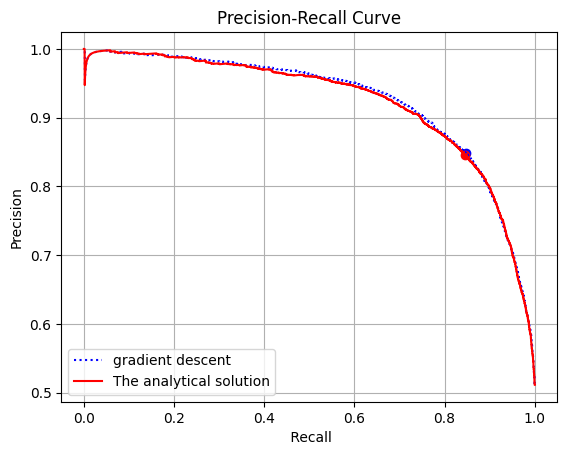

In [18]:
plt.plot(recall_test,precision_test,label='gradient descent',color='blue',linestyle=':')
plt.plot(recall_test1,precision_test1,label='The analytical solution',color='red',linestyle='-')
plt.scatter(balance_point[i],balance_point[0],color='b',marker='o')
plt.scatter(balance_point1[i],balance_point1[0],color='r',marker='o')
#添加标题和坐标轴标签
plt.title('Precision-Recall Curve')
plt.xlabel(' Recall')
plt.ylabel('Precision')
#添加图例和网格线
plt.legend()
plt.grid()
plt.show() 

In [ ]:

# ============== 通过梯度下降求解 ==============

x = Input(shape=(train_x.shape[1],))
y = Dense(1, activation='sigmoid')(x)
best_score
for i in range(100):
    model = Model(x, y)
    model.compile(
        loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy']
    )
    model.summary()

    model.fit(
        train_x,
        train_y,
        epochs=10,
        batch_size=32,
        validation_data=(valid_x, valid_y)
    )

train_y_pred = model.predict(train_x, verbose=True)
valid_y_pred = model.predict(valid_x, verbose=True)
test_y_pred = model.predict(test_x, verbose=True)
train_acc = np.mean((train_y == 1) == (train_y_pred > 0.5))
valid_acc = np.mean((valid_y == 1) == (valid_y_pred > 0.5))
test_acc = np.mean((test_y == 1) == (test_y_pred > 0.5))
print(train_acc, valid_acc, test_acc)
